In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model   import LogisticRegression
from sklearn.model_selection  import train_test_split
from sklearn.feature_selection import f_classif
from  sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import KFold
from  sklearn.model_selection import StratifiedKFold
import missingno as msno
import seaborn as sns
from sklearn.feature_selection import SelectPercentile
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing  import PolynomialFeatures


*OBJECTIVE:For this episode of the series, your task is to use binary classification to predict a patient's smoking status, given information on various other health indicators.*

*EVALUATION:Submissions are evaluated in the area under the ROC curve between the predicted probability and the observed goal.*

# 1-*IMPORTING DATA*

In [119]:
data_train=pd.read_csv(
    '/content/train.csv',
    encoding='utf-8'
)

data_test=pd.read_csv(
    '/content/test.csv',
    encoding='utf--8'
)

submission_data=pd.read_csv('/content/sample_submission.csv',
                            encoding='utf-8')

In [3]:
data_train.head(5)

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [145]:
data_test.shape,data_train.shape

((106171, 23), (159256, 24))

In [4]:
data_test.head(5)

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


2-EDA-*ANALYSIS*

*1-checking data nulls*

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<Axes: >

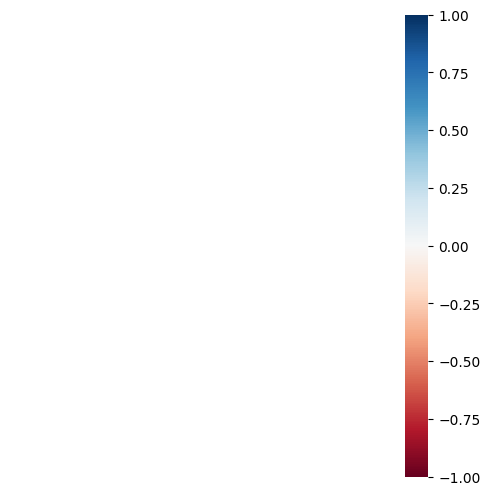

In [5]:
msno.heatmap(data_train.sample(250),figsize=(6,6))

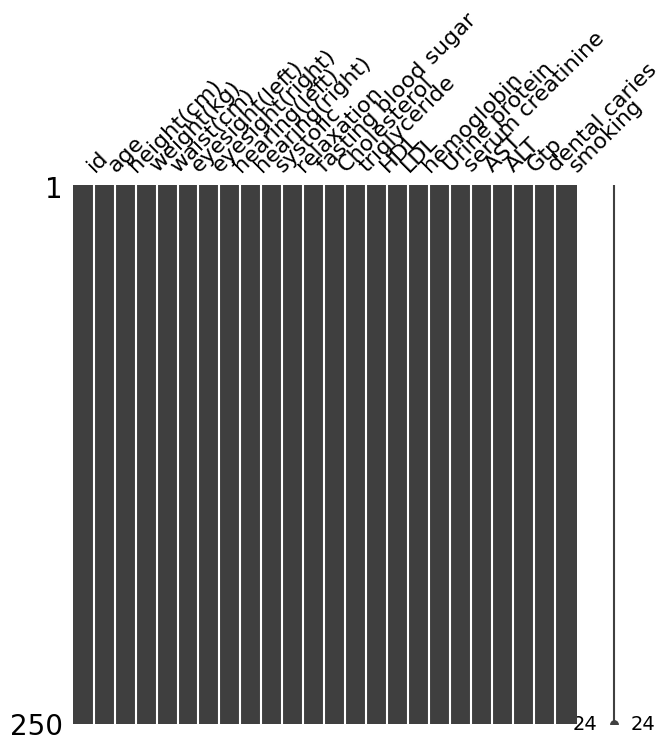

In [6]:
ax=msno.matrix(data_train.sample(250),figsize=(7.2,7))

In [7]:
data_train.isna().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [8]:
data_train['smoking'].value_counts()

0    89603
1    69653
Name: smoking, dtype: int64

<Axes: >

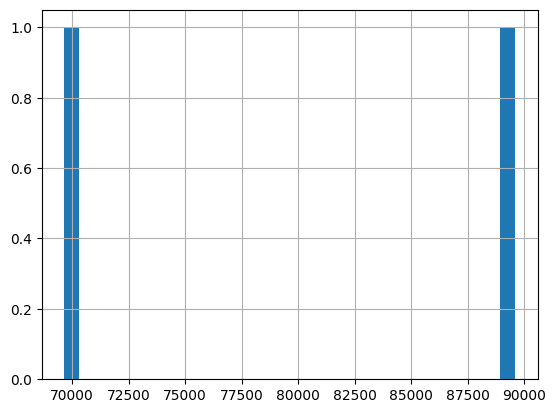

In [9]:
data_train['smoking'].value_counts().hist(bins=30)

*There is no data imbalance, the data is balanced*

In [10]:
data_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

*2-rename columns Renaming columns that have ()*

In [11]:
data_train.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [12]:
data_train.rename(columns={'height(cm)':'height',
                           'weight(kg)':'weight',
                           'waist(cm)':'waist',
                           'eyesight(left)':'eyesightleft',
                           'eyesight(right)':'eyesightright',
                           'hearing(left)':'hearingleft',
                           'hearing(right)':'hearingright',
                           'fasting blood sugar':'fastingbloodsugar',
                           'Urine protein':'Urineprotein',
                           'serum creatinine':'serumcreatinine',
                           'dental caries':'dentalcaries'},
                  inplace=True)

data_test.rename(columns={'height(cm)':'height',
                           'weight(kg)':'weight',
                           'waist(cm)':'waist',
                           'eyesight(left)':'eyesightleft',
                           'eyesight(right)':'eyesightright',
                           'hearing(left)':'hearingleft',
                           'hearing(right)':'hearingright',
                           'fasting blood sugar':'fastingbloodsugar',
                           'Urine protein':'Urineprotein',
                           'serum creatinine':'serumcreatinine',
                           'dental caries':'dentalcaries'},
                  inplace=True)

In [13]:
data_train.columns

Index(['id', 'age', 'height', 'weight', 'waist', 'eyesightleft',
       'eyesightright', 'hearingleft', 'hearingright', 'systolic',
       'relaxation', 'fastingbloodsugar', 'Cholesterol', 'triglyceride', 'HDL',
       'LDL', 'hemoglobin', 'Urineprotein', 'serumcreatinine', 'AST', 'ALT',
       'Gtp', 'dentalcaries', 'smoking'],
      dtype='object')

*3-checking duplicates data*

In [14]:
data_train['id'].value_counts()

0         1
106173    1
106166    1
106167    1
106168    1
         ..
53086     1
53087     1
53088     1
53089     1
159255    1
Name: id, Length: 159256, dtype: int64

In [15]:
data_train['id'].nunique()

159256

In [16]:
data_train.shape

(159256, 24)

In [17]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 159256 non-null  int64  
 1   age                159256 non-null  int64  
 2   height             159256 non-null  int64  
 3   weight             159256 non-null  int64  
 4   waist              159256 non-null  float64
 5   eyesightleft       159256 non-null  float64
 6   eyesightright      159256 non-null  float64
 7   hearingleft        159256 non-null  int64  
 8   hearingright       159256 non-null  int64  
 9   systolic           159256 non-null  int64  
 10  relaxation         159256 non-null  int64  
 11  fastingbloodsugar  159256 non-null  int64  
 12  Cholesterol        159256 non-null  int64  
 13  triglyceride       159256 non-null  int64  
 14  HDL                159256 non-null  int64  
 15  LDL                159256 non-null  int64  
 16  he

In [18]:
data_train['weight']=data_train['weight'].astype(np.float64)
data_train['height']=data_train['height'].astype(np.float64)

data_test['weight']=data_test['weight'].astype(np.float64)
data_test['height']=data_test['height'].astype(np.float64)

4-*There are many features, and investigating them all takes time, so we can do an ANOVA mean test, to check for features that are useful and have a statistically significant mean response variable*

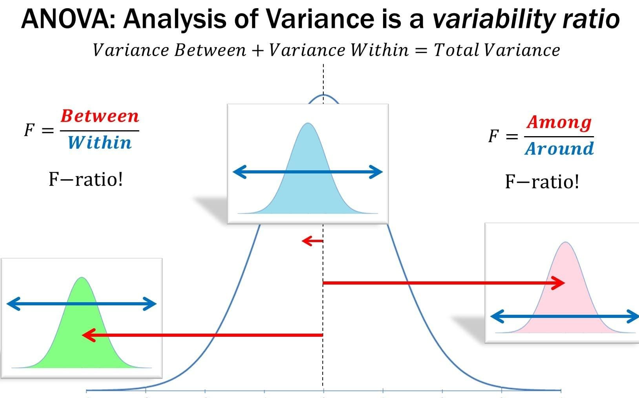

a) *Anova is a hypothesis test, we have the null hypothesis Ho which represents the null hypothesis with 95% confidence that there is no difference between the media, we have the alternative hypothesis which is controversial to the null hypothesis H1*

b) *ANOVA relates the ratio between the variation within the sample and the variation outside the sample*

*c) The anova test answers the following question, what is the mean of this characteristic in the response variable ? if it is statistically significant, then it is a good characteristic*

F= Variability (between groups)/
   Variability (within groups)

 *  If the variability between the groups is greater, then we reject the m null hypothesis, and say that the means are statistically significant, if the variability within the groups is greater, then the null hypopole holds, this means that the means are not statistically significant*

In [19]:
feature_corr=data_train.columns.tolist()

In [20]:
X=data_train[feature_corr].iloc[:,:-1].values
y=data_train[feature_corr].iloc[:,-1].values


In [21]:
print(X.shape,y.shape)

(159256, 23) (159256,)


In [22]:
[f_stat,p_value]=f_classif(X,y)

In [23]:
data_f=pd.DataFrame({'statistic_sign':feature_corr[:-1],
                    'F_statistic':f_stat,
                    'P_value':p_value})

In [24]:
data_f.sort_values('F_statistic',ascending=False).head(10)

,statistic_sign,F_statistic,P_value
16,hemoglobin,40590.708903,0.0
2,height,39790.683120,0.0
3,weight,22486.078271,0.0
13,triglyceride,19724.800842,0.0
21,Gtp,16400.422001,0.0
18,serumcreatinine,12822.695824,0.0
14,HDL,12641.478027,0.0
4,waist,11806.430639,0.0
1,age,7059.957676,0.0
20,ALT,4347.585557,0.0


*We can see , that an increase in the F statistic , has a decrease in p , this means that these characteristics are statistically significant*

In [25]:
data_mask=(data_f['P_value']==0.0)
data_f['F_statistic'][data_mask]

1      7059.957676
2     39790.683120
3     22486.078271
4     11806.430639
5      1622.289991
6      1942.728630
10     1932.704519
11     1498.031452
13    19724.800842
14    12641.478027
16    40590.708903
18    12822.695824
20     4347.585557
21    16400.422001
22     1831.752533
Name: F_statistic, dtype: float64

In [26]:
data_f['statistic_sign'][data_mask]

1                   age
2                height
3                weight
4                 waist
5          eyesightleft
6         eyesightright
10           relaxation
11    fastingbloodsugar
13         triglyceride
14                  HDL
16           hemoglobin
18      serumcreatinine
20                  ALT
21                  Gtp
22         dentalcaries
Name: statistic_sign, dtype: object

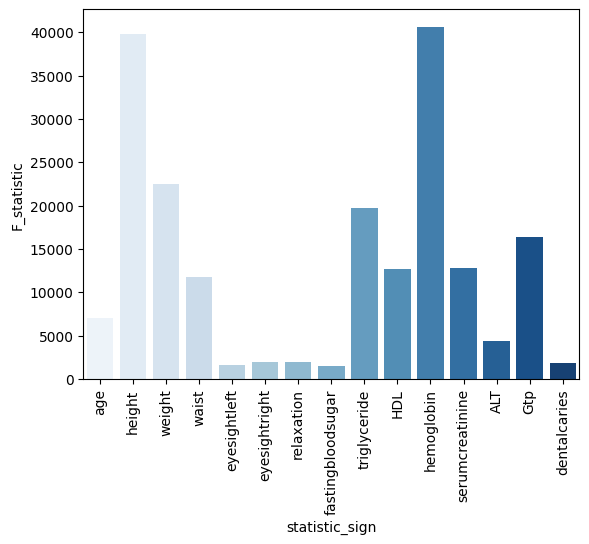

In [27]:
sns.barplot(x=data_f['statistic_sign'][data_mask],y=data_f['F_statistic'][data_mask],
            palette='Blues')
plt.xticks(rotation=90)
plt.show()


*that we can see that the trait with the highest stat f is hemoglobin*

*5-Visualizations*

In [28]:
feature_itrx=data_f['statistic_sign'][data_mask]

In [29]:
corr=data_train[feature_itrx].corr()

In [30]:
corr.iloc[0:5,0:5]

,age,height,weight,waist,eyesightleft
age,1.000000,-0.489608,-0.336859,-0.045369,-0.269495
height,-0.489608,1.000000,0.686645,0.409500,0.209997
weight,-0.336859,0.686645,1.000000,0.830208,0.151794
waist,-0.045369,0.409500,0.830208,1.000000,0.046964
eyesightleft,-0.269495,0.209997,0.151794,0.046964,1.000000


<Axes: >

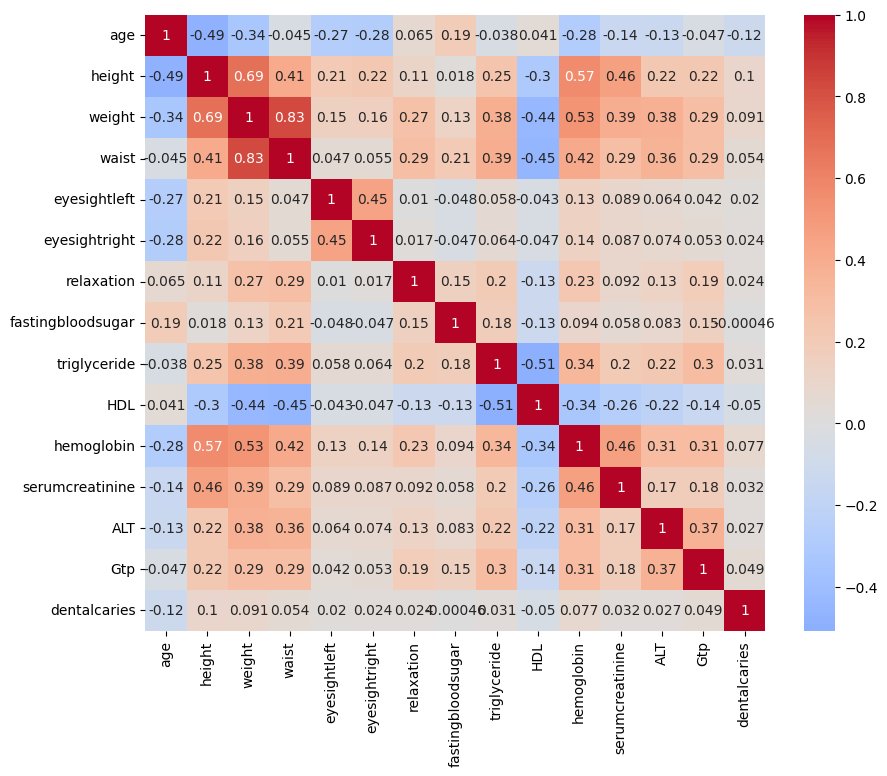

In [31]:
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0,
            annot=True,
            cmap='coolwarm')

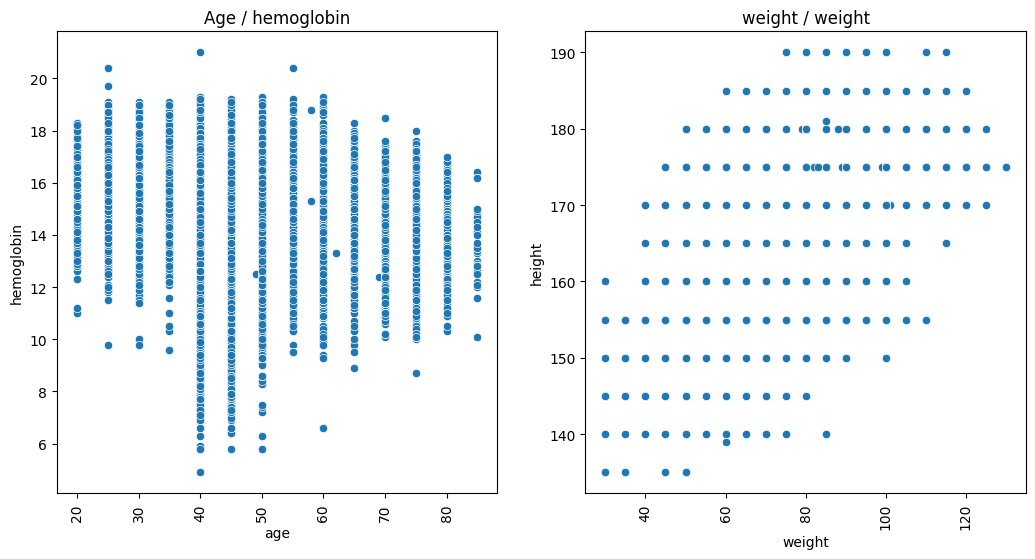

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.5, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=data_train['age'], y=data_train['hemoglobin'], data=data_train)
plt.title('Age / hemoglobin')
plt.xticks(rotation=90)


plt.subplot(1, 2, 2)
sns.scatterplot(x=data_train['weight'], y=data_train['height'], data=data_train)
plt.title('weight / weight')
plt.xticks(rotation=90)

plt.show()

2-DATA PREPARATION

*With anova, we already have the traits that are statistically significant, so we can take those that are the 50 ...*

*Univariate feature selection(Anova)*

In [33]:
selector=SelectPercentile(f_classif,percentile=50)

In [34]:
selector.fit(X,y)

SelectPercentile(percentile=50)

In [35]:
best_itrx=selector.get_support()

In [36]:
features=feature_itrx[:-1]

In [37]:
best_features=[features[counter] for counter in range(len(features)) if best_itrx[counter]]

In [38]:
best_features

['age', 'height', 'weight', 'waist', 'eyesightright', 'triglyceride']

*Let's see how the model performs with these 20% of the best features*

*Separate Training and test data*

In [39]:
X_train,X_test,y_train,y_test=train_test_split(
    data_train[['height','weight','triglyceride','hemoglobin']].values,
    data_train['smoking'].values,
    test_size=0.2,
    random_state=42
)

*1-Initially we don't know what the performance of the model with these characteristics will be to adjust the parameters, so first we will see the performance first*

*I will use the logistic regression classification model, in order to maximize the maximum likelihood estimate*



In [40]:
model_machine=LogisticRegression()

*Training the model*

In [41]:
model_machine.fit(X_train,y_train)

LogisticRegression()

In [42]:
y_pred=model_machine.predict(X_test)

*1-The first metric we're going to look at is model accuracy... Attention accuracy is not one of the best metrics to deal with unbalanced classes, however the model classes are well balanced, but we just want to see how our model is doing*

In [43]:
is_correct=y_pred==y_test

In [44]:
np.mean(is_correct)

0.7270187115408766

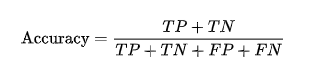

The accuracy is  0.7109757629034283,is good ?



*It depends, let's check how the model is dealing with false positives, true positives, false negatives, true negatives*

1-TPR-(true positive rate) is the proportion of samples that the model was able  
  to classify correctly.

  a)-TP-(True positive rate) is the sum where both in the test labels is 1 and in the prediction is also 1

  b)-P (postive sample) is the proportion of samples in the positive class


In [45]:
P=np.sum(y_test==1)

In [46]:
TP=np.sum((y_pred==1)&(y_test==1))

In [47]:
TP

10016

In [48]:
TPR=TP/P

In [49]:
TPR

0.7119198237259222

  1-N (negative sample) is the sum of samples that belong to the negative class

  a)-TNR-(true negative rate) is the proportion of negative class samples that have been correctly classified
  
  b)-TN-(true negative) TN is the sum of negative class where in the test label is 0 and in the prediction it is also 0

    


In [50]:
N=np.sum(y_test==0)

In [51]:
N

17783

In [52]:
TN=np.sum((y_pred==0) & (y_test==0))

In [53]:
TN

13141

In [54]:
TNR=TN/N

In [55]:
TNR

0.7389641792723387

1-FPR-(False positive rate) It is the proportion of samples where on the test
 label is 0 and prediction is 1


a)-FP-(False positive) is the sum where in the test roll is 0 and in the
  prediction is 1



In [56]:
FP=np.sum((y_pred==1) & (y_test==0))

In [57]:
FP

4642

In [58]:
FPR=FP/N

In [59]:
FPR

0.26103582072766124

1-FNR-(False negative rate ) is the quantity of samples where in the test label
   is 1 and in the data prediction is 0

a)-FN-(False negative)
Inglês
is the sum of the quantities of amotras where in the test label is 1 and in the prediction of the data made by the model is 0


In [60]:
FN=np.sum((y_pred==0) & (y_test==1))

In [61]:
FN

4053

In [62]:
FNR=FN/N

In [63]:
FNR

0.2279143001743238

In [64]:
mapp_dict={ 'TPR':TPR,
            'TNR':TNR,
            'FPR':FPR,
            'FNR':FNR}

In [65]:
for  T,N in mapp_dict.items():
  print(T,N)

TPR 0.7119198237259222
TNR 0.7389641792723387
FPR 0.26103582072766124
FNR 0.2279143001743238


*Summary Confusion Matrix*

In [66]:
metrics.confusion_matrix(y_test,y_pred)

array([[13141,  4642],
       [ 4053, 10016]])

*A good classifier would have the secondary diagonal , both (false positives and negatives) close to 0 , but we can see that here there is no , which the classicator has trouble in deciphering the classes*

*Let's look at the roc curve to analyze*

In [67]:
y_proba=model_machine.predict_proba(X_test)

In [68]:
y_proba

array([[0.14442641, 0.85557359],
       [0.22157707, 0.77842293],
       [0.41499013, 0.58500987],
       ...,
       [0.15147485, 0.84852515],
       [0.55105281, 0.44894719],
       [0.26969117, 0.73030883]])

*We can see that the second column represents the predicted probabilities (scores) for the positive classes and the first represents the negative*

*Distribution of predicted probabilities*

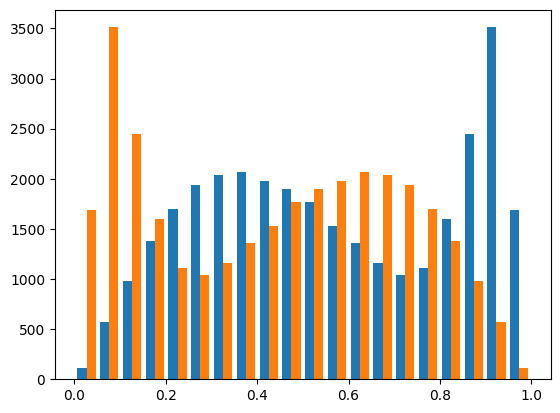

In [69]:
plt.hist(y_proba,bins=20)
plt.show()

*What happens if we keep lowering our limit?*

Text(0, 0.5, 'Number of samples')

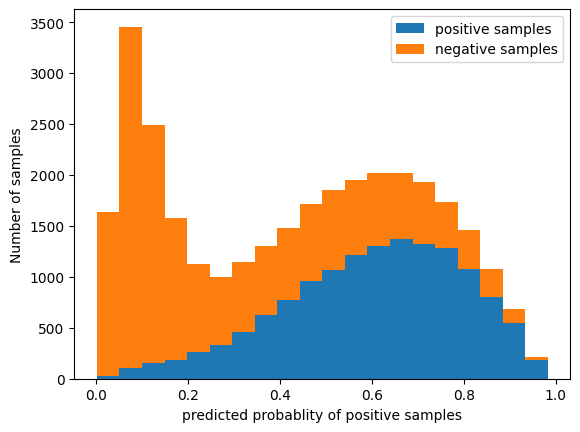

In [70]:
pos_proba=y_proba[:,1]
pos_samples_pos_proba=pos_proba[y_test==1]
neg_samples_pos_proba=pos_proba[y_test==0]

plt.hist([pos_samples_pos_proba,neg_samples_pos_proba],
         histtype='barstacked',bins=(20))

plt.legend(['positive samples','negative samples'])
plt.xlabel('predicted probablity of positive samples')
plt.ylabel('Number of samples')


*We can see that as we continue to lower our threshold, we will notice that many samples rated as 1 would actually be false positives, our goal is simply to recover the true positives, however the same thing happens if we increase our threshold too much, we would have a lot of false negatives, so it would be a trade-off between sensitivity and precision*

*Let's see what the roc curve looks like for different limits..*

In [71]:
fpr,tpr,thresolds=metrics.roc_curve(y_test,y_proba[:,1])

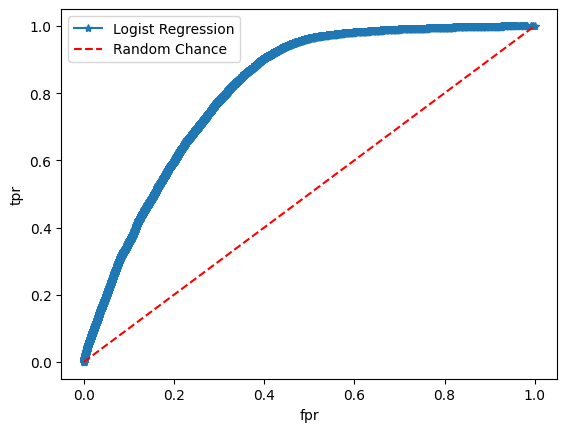

In [72]:
plt.plot(fpr,tpr,'*-')
plt.plot([0,1],[0,1],'--r')
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.legend(['Logist Regression','Random Chance'])


*We can see that a good classifier would extend the upper right corner, it would start from a threshold (0,0) and go up to (0,1), but this doesn't happen. Here we just see different decision limits, for different probabilities classified as positive by the model*

Statistic C

The C statistic, also known as the area over the roc curve, if the area over the roc curve is greater than 0.5, then it means that the model is performing very well, if not, we can already say that the classifier has problems

In [73]:
y_pred_proba=metrics.roc_auc_score(
    y_test,y_proba[:,1]
)

In [74]:
y_pred_proba

0.8097920937196019

*With this auc , we can say that the model is good, but it can still be improved by precaution , let's see if the model has high variance (overfitting) or high systematic error (bias)*

In [75]:
y_pred_train=model_machine.predict_proba(X_train)
y_pred_train_proba=metrics.roc_auc_score(y_train,y_pred_train[:,1])
y_pred_train_proba

0.8103527045531134

*We can see that the model is overfitting the data a bit, it is remarkable because we have many features in the model, when we have many features and few features, we are likely to have problems with overfitting in the data, what to do to readjust to solve these problems?*

1-We can add more samples

2-We can make a selection of better features

3-We can use regularization

*1-Making a selection of better features, can be useful to reduce the issue of overfitting, but it has a disadvantage because of the loss of information, because by eliminating features, we are discarding information*

*2-So, the best option would be to use regularization ,to penalize the high coefficients, either in the positive or negative direction. because? Because a high coefficient in either the positive or negative direction, it can cause overfitting problems*

*Let's use regularization to decrease overfitting*

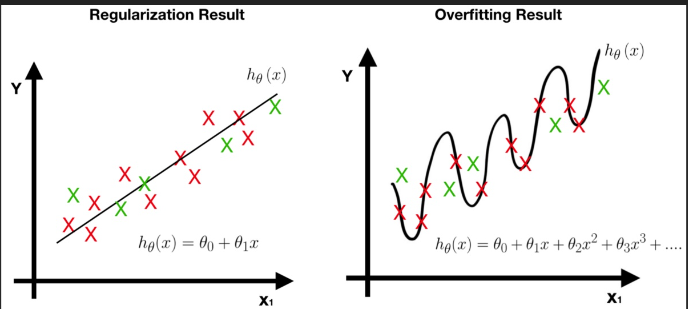

*We can see that regularization happens when we have too many features, the model tries to adjust excessively in all data points, leaving it with random noise, with impatience to follow the right predictions of the real world out there*

*To solve this problem, we just need to add a penalty to the high coefficients in the cost function of logistic regression.*

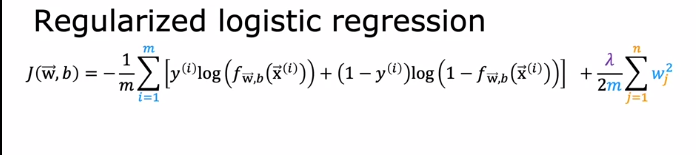

*but which parameter to choose ?.. Note that if we choose a very large lambda value it is because the coefficients of our model are small, this multiplication will cause the coefficients to be close to zero and this will not help the model, we would have another problem of high trend in the data, underfitting, the model would not be able to fit well to the training data*

*To do this, we need to find a good hyperparameter that is neither too high nor too low. but it penalizes the coefficients in the right way and results in good predictions .. Or we can also add a bit of systematic error in the training data (underfitting) to improve out-of-sample performance in the test set*

*I will use ridge regression or also called l1 regularization, this type of regularization penalizes the coefficients towards 0 , but not exactly as zero.. with this we will not delete all the selected traits, but rather we will penalize them .i will do this together with the cross-validation to test different hyperparameters for different values of C (lambda)*

*It is essential that when we are going to do the cross-validation it is necessary to take into account that if we are going to test different hyperparameters for new test set for each training sample it is necessary to scramble the data in the test set because of the systematic errors ... That is.. We need to scramble the data in each test suite so that each k_fold in the test suite has the same emphasis as the others To do this, we set the shuffle parameter to True*


**Example of Stratified Samples**

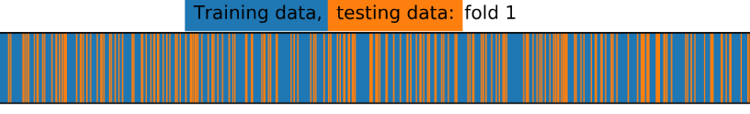

3- HYPERPARAMETER SEARCH / CROSS-VALIDATION


In [76]:
n_folds=4

In [77]:

k_folds=StratifiedKFold(n_splits=n_folds,
                        shuffle=True,
                        random_state=1)

In [78]:
C_vals_exponents=np.linspace(-7,7,17)

In [79]:
C_vals_exponents

array([-7.   , -6.125, -5.25 , -4.375, -3.5  , -2.625, -1.75 , -0.875,
        0.   ,  0.875,  1.75 ,  2.625,  3.5  ,  4.375,  5.25 ,  6.125,
        7.   ])

In [80]:
C_vals=np.float(10)**C_vals_exponents

<ipython-input-80-8949cfbe230e>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  C_vals=np.float(10)**C_vals_exponents


In [81]:
C_vals

array([1.00000000e-07, 7.49894209e-07, 5.62341325e-06, 4.21696503e-05,
       3.16227766e-04, 2.37137371e-03, 1.77827941e-02, 1.33352143e-01,
       1.00000000e+00, 7.49894209e+00, 5.62341325e+01, 4.21696503e+02,
       3.16227766e+03, 2.37137371e+04, 1.77827941e+05, 1.33352143e+06,
       1.00000000e+07])

In [82]:
def Search_val_C (k_folds,C_vals,model,X,y):

  n_folds=k_folds.n_splits
  cv_train_roc_auc=np.empty((n_folds,len(C_vals))) #Here we create empty vectors for different C-values for both test and both training
  cv_test_roc_auc=np.empty((n_folds,len(C_vals)))
  cv_test_roc_curve = [[]]*len(C_vals)  #Here we create a sublist to store all the C values for the tpr fpr metrics with their thresholds

  for c_val_counter in range(len(C_vals)): #traversing each value of C i inserting into the model
    model.C=C_vals[c_val_counter]
    folder_counter=0

    for train_index,test_index in k_folds.split(X,y):# cross-validation by going through each training and test fold with different values of C for each iteration
      X_train_cv , X_test_cv=X[train_index],X[test_index]
      y_cv_train , y_cv_test=y[train_index],y[test_index]

      model.fit(X_train_cv,y_cv_train)

      y_proba_train_cv=model.predict_proba(X_train_cv) #Here we are predicting the predicted probabilities of the model for both the training and saving cases in the vectors..
      cv_train_roc_auc[folder_counter,c_val_counter]=metrics.roc_auc_score(y_cv_train,y_proba_train_cv[:,1])

      y_proba_test_cv=model.predict_proba(X_test_cv) #Here we are predicting the predicted probabilities of the model for both the test cases and saving in the vectors.
      cv_test_roc_auc[folder_counter,c_val_counter]=metrics.roc_auc_score(y_cv_test,y_proba_test_cv[:,1])

      folder_curve=metrics.roc_curve(y_cv_test,y_proba_test_cv[:,1])
      cv_test_roc_curve[c_val_counter].append(folder_curve)# Here for different C values, we're saving the tpr and fpr metrics

      folder_counter+=1

      print('Done with C = {}'.format(model.C)) #printing the templates for different C-values

  return cv_train_roc_auc,cv_test_roc_auc,cv_test_roc_curve





In [83]:
cv_train_roc_auc,cv_test_roc_auc,cv_test_roc = Search_val_C(k_folds,C_vals,model_machine,X_train,y_train)

Done with C = 1e-07
Done with C = 1e-07
Done with C = 1e-07
Done with C = 1e-07
Done with C = 7.498942093324558e-07
Done with C = 7.498942093324558e-07
Done with C = 7.498942093324558e-07
Done with C = 7.498942093324558e-07
Done with C = 5.623413251903491e-06
Done with C = 5.623413251903491e-06
Done with C = 5.623413251903491e-06
Done with C = 5.623413251903491e-06
Done with C = 4.216965034285822e-05
Done with C = 4.216965034285822e-05
Done with C = 4.216965034285822e-05
Done with C = 4.216965034285822e-05
Done with C = 0.00031622776601683794
Done with C = 0.00031622776601683794
Done with C = 0.00031622776601683794
Done with C = 0.00031622776601683794
Done with C = 0.0023713737056616554
Done with C = 0.0023713737056616554
Done with C = 0.0023713737056616554
Done with C = 0.0023713737056616554
Done with C = 0.01778279410038923
Done with C = 0.01778279410038923
Done with C = 0.01778279410038923
Done with C = 0.01778279410038923
Done with C = 0.1333521432163324
Done with C = 0.13335214321

*Result of cross-validation to regularize the model*

*Now we're going to check it out visually*


In [84]:
cmap = plt.get_cmap()

Text(0.5, 1.0, 'cross_validation scores for each fold')

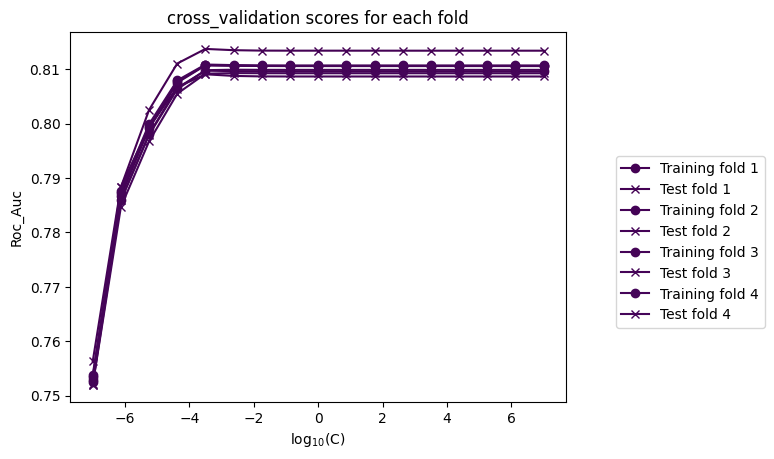

In [85]:
for this_fold in range(n_folds):
    plt.plot(C_vals_exponents, cv_train_roc_auc[this_fold], '-o',
             color=cmap(this_fold), label='Training fold {}'.format(this_fold + 1))
    plt.plot(C_vals_exponents, cv_test_roc_auc[this_fold], '-x',
             color=cmap(this_fold), label='Test fold {}'.format(this_fold + 1))

plt.ylabel('Roc_Auc')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc=[1.1,0.2])
plt.title('cross_validation scores for each fold')



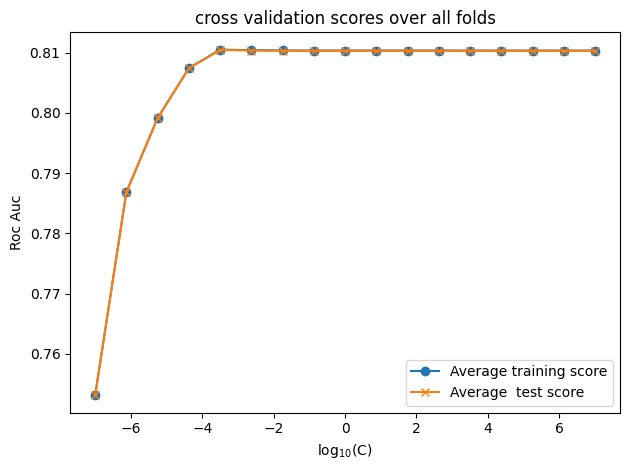

In [86]:
plt.plot(C_vals_exponents,np.mean(cv_train_roc_auc,axis=0),'-o',
         label='Average training score')
plt.plot(C_vals_exponents,np.mean(cv_test_roc_auc,axis=0),'-x',
         label='Average  test score')
plt.ylabel('Roc Auc')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('cross validation scores over all folds')
plt.tight_layout()


*In this plot it is clear that C=10^-2.5 and C=10^-3.5 are the best values for C to decrease regularization*

*In this case we need to find the index where where C=a this value and substitute it for our model*


In [87]:
C_vals_exponents

array([-7.   , -6.125, -5.25 , -4.375, -3.5  , -2.625, -1.75 , -0.875,
        0.   ,  0.875,  1.75 ,  2.625,  3.5  ,  4.375,  5.25 ,  6.125,
        7.   ])

In [88]:
best_C_val_bool=C_vals_exponents==-3.5
best_C_val_bool.astype(int)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [89]:
best_C_val_itx=np.nonzero(best_C_val_bool.astype(np.int))
best_C_val_itx[0][0]

<ipython-input-89-6d463fff5dc4>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_C_val_itx=np.nonzero(best_C_val_bool.astype(np.int))


4

*Since we've already found this value, let's access the true positives and false positives ratios to plot the tail fold roc curves*

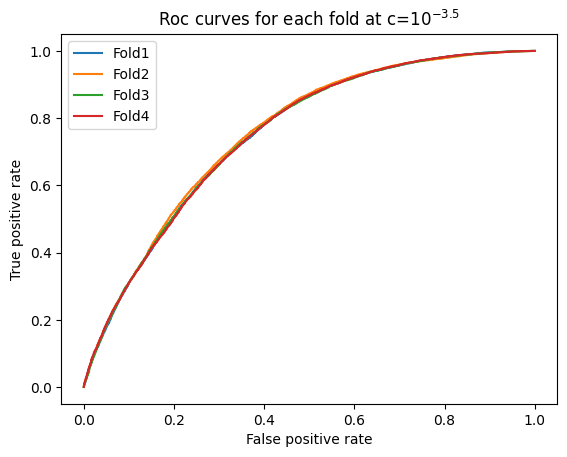

In [90]:
for this_fold in range(n_folds):
  fpr=cv_test_roc[best_C_val_itx[0][0]][this_fold][0]
  tpr=cv_test_roc[best_C_val_itx[0][0]][this_fold][1]
  plt.plot(fpr,tpr,label='Fold{}'.format(this_fold+1))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Roc curves for each fold at c=$10^{-3.5}$')
plt.legend()

*Now we can grab these values.. and use in our logistic regression model*

In [91]:
model_machine.C=10**(-3.5)
model_machine.fit(X_train,y_train)

LogisticRegression(C=0.00031622776601683794)

*Now again, let's use the C statistic to calculate the area on the roc curve for both the test and training data*

In [92]:
y_proba_roc_train=model_machine.predict_proba(X_train)
y_proba_feature_train=metrics.roc_auc_score(y_train,y_proba_roc_train[:,1])
y_proba_feature_train

0.8105210960309124

In [93]:
y_proba_roc_test=model_machine.predict_proba(X_test)
y_proba_feature_test=metrics.roc_auc_score(y_test,y_proba_roc_test[:,1])
y_proba_feature_test

0.8099509216285492

*In this way we can see that the regularization has slightly increased the area on the roc curve in the test data, however, it still continues to have a lower performance in relation to the training data, is this good? It depends, the difference is not statistically significant... So we can say that there is no difference, if the difference were accentuated we could be worried, but that is not the case*

*We know that L1 regularization operates by decreasing the coefficients, so let's see how many coefficients were not set to zero*

In [94]:
sum((model_machine.coef_!=0))[0]

1

*Only one of the coefficients of the best characteristics I selected was not considered zero*

In [95]:
model_machine.intercept_

array([-22.94183029])

*What can we do now? ,well we could think about creating engineering features , i.e. iteration features ... Often the relationship between predictor variables of a linear model is not expressed in terms of the linear combination of the resultant or dependent variable*

*4-Cross-Validation and Feature Engineering with the Case Study Data*

*Here we will use cross validation with feature engineering and regularization, but for this we need to scale the data using pipelines, regularization is sensitive to values ​​that are not on the same scale, so we need to scale..not only in the training data, but for each unknown test set in each fold, to ensure that this unknown data has the same emphasis*

In [96]:
X_train_1,X_test_1,y_train_1,y_test_1=train_test_split(
    data_train[features].values,
    data_train['smoking'].values,
    test_size=0.2,
    random_state=24
)



*Here we initialize the scheduler, and configure the solver for saga, and use the pipeline*

In [97]:

min_max_sc=MinMaxScaler()

model_lr=LogisticRegression(solver='saga',
                            penalty='l1',
                            max_iter=1000)

scale_lr_pipeline=Pipeline(steps=[('scaler',min_max_sc)
   ,('model',model_lr)])


In [98]:
scale_lr_pipeline.get_params()
scale_lr_pipeline.get_params()['model__C']
scale_lr_pipeline.set_params(model__C=2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [99]:
C_vals_exponents_1=np.linspace(-2,3,6)
C_vals_1=np.float(10)**C_vals_exponents_1

<ipython-input-99-fcb2ad167874>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  C_vals_1=np.float(10)**C_vals_exponents_1


In [100]:
C_vals_1

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

*Here, we changed the previous function, included just a few changes... now we scale the features for each folder in the test data and training set using cross-validation with regularization for each different value of C*


In [101]:
def cross_val_search_pipeline(
    k_folds,C_vals,pipeline,
    X,y):

  n_folds=k_folds.n_splits
  cv_train_roc_auc=np.empty((n_folds,len(C_vals_1)))
  cv_test_roc_auc=np.empty((n_folds,len(C_vals_1)))
  cv_test_roc_curve=[[]]*len(C_vals_1)

  for c_vals_counter in range(len(C_vals_1)):
    pipeline.set_params(model__C=C_vals_1[c_vals_counter])
    folder_counter=0

    for train_index,test_index in k_folds.split(X,y):
      X_cv_train,X_cv_test=X[train_index],X[test_index]
      y_cv_train,y_cv_test=y[train_index],y[test_index]

      pipeline.fit(X_cv_train,y_cv_train)

      y_cv_proba_train=pipeline.predict_proba(X_cv_train)
      cv_train_roc_auc[folder_counter,c_vals_counter]=metrics.roc_auc_score(y_cv_train,y_cv_proba_train[:,1])

      y_cv_proba_test=pipeline.predict_proba(X_cv_test)
      cv_test_roc_auc[folder_counter,c_vals_counter]=metrics.roc_auc_score(y_cv_test,y_cv_proba_test[:,1])

      folder_curve=metrics.roc_curve(y_cv_test,y_cv_proba_test[:,1])
      cv_test_roc_curve[c_vals_counter].append(folder_counter)
      folder_counter+=1

      print('Done with C={}'.format(pipeline.get_params()['model__C']))


  return cv_train_roc_auc,cv_test_roc_auc,cv_test_roc_curve




In [102]:
cv_train_roc_auc_1,cv_test_roc_auc_1,cv_test_roc_curve_1=cross_val_search_pipeline(k_folds,C_vals_1,scale_lr_pipeline,X_train_1,y_train_1)

Done with C=0.01
Done with C=0.01
Done with C=0.01
Done with C=0.01
Done with C=0.1
Done with C=0.1
Done with C=0.1
Done with C=0.1
Done with C=1.0
Done with C=1.0
Done with C=1.0
Done with C=1.0
Done with C=10.0
Done with C=10.0
Done with C=10.0
Done with C=10.0
Done with C=100.0
Done with C=100.0
Done with C=100.0
Done with C=100.0
Done with C=1000.0
Done with C=1000.0
Done with C=1000.0
Done with C=1000.0


*Here we can see how the graph looked after cross validation+pipelines+regularization*

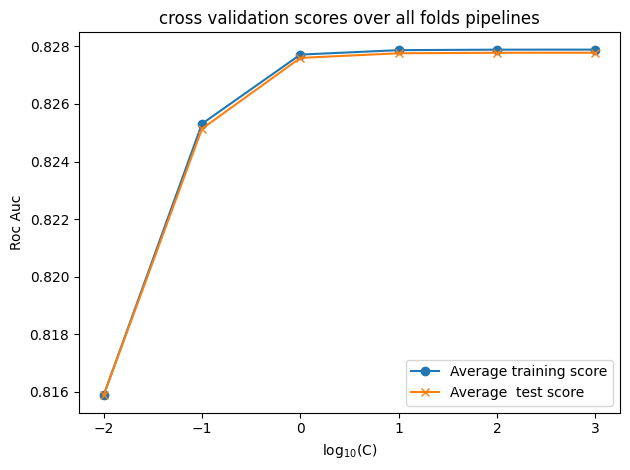

In [103]:
plt.plot(C_vals_exponents_1,np.mean(cv_train_roc_auc_1,axis=0),'-o',
         label='Average training score')
plt.plot(C_vals_exponents_1,np.mean(cv_test_roc_auc_1,axis=0),'-x',
         label='Average  test score')

plt.ylabel('Roc Auc')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('cross validation scores over all folds pipelines')
plt.tight_layout()

*With this we can see that we had an increase in the test data..do we still have a little overfitting? we will see*


*here we can also see that a value of C =10^2 improved the model in the test cases*


In [104]:
C_vals_exponents_1

array([-2., -1.,  0.,  1.,  2.,  3.])

In [105]:
best_C_val_bool=C_vals_exponents_1==2
best_C_val_bool.astype(int)

best_C_val_itx=np.nonzero(best_C_val_bool.astype(np.int))
best_C_val_itx[0][0]

<ipython-input-105-ed5a1d2a99d3>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_C_val_itx=np.nonzero(best_C_val_bool.astype(np.int))


4

*Here we replace the value of C with the value that presents the best results in the test scores we performed with cross-validation. And we train the new staggered and regularized model*

In [106]:
scale_lr_pipeline.C=10**(2)
scale_lr_pipeline.fit(X_train_1,y_train_1)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=1000.0, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [107]:
y_proba_roc_test=scale_lr_pipeline.predict_proba(X_test_1)
y_proba_feature_test=metrics.roc_auc_score(y_test_1,y_proba_roc_test[:,1])
y_proba_feature_test

0.83315840233568

In [108]:
y_proba_roc_train=scale_lr_pipeline.predict_proba(X_train_1)
y_proba_feature_train=metrics.roc_auc_score(y_train_1,y_proba_roc_train[:,1])
y_proba_feature_train

0.8278776327374348

*Well, what happened? It seems that now we have a better model... the results of the area on the roc curve are better in the test data compared to the training data, we had an improvement in relation to the data scaled using pipelines.*

In [109]:
make_iterations=PolynomialFeatures(degree=2,
                                   interaction_only=True,
                                   include_bias=False)

X_interact=make_iterations.fit_transform(data_train[features])
X_interact_test=make_iterations.fit_transform(data_test[features])

X_train_2,X_test_2,y_train_2,y_test_2=train_test_split(
    X_interact,data_train['smoking'].values,
    test_size=0.2,
    random_state=24
)

print(X_train_2.shape)
print(X_test_2.shape)

(127404, 105)
(31852, 105)


In [110]:
cv_train_roc_auc_2,cv_test_roc_auc_2,cv_test_roc_curve_2=cross_val_search_pipeline(k_folds,C_vals_1,scale_lr_pipeline,X_train_2,y_train_2)

Done with C=0.01
Done with C=0.01
Done with C=0.01
Done with C=0.01
Done with C=0.1
Done with C=0.1
Done with C=0.1
Done with C=0.1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=10.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=10.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=10.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=10.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=100.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=100.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=100.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=100.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=1000.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=1000.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C=1000.0
Done with C=1000.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


*Here we use feature engineering to improve the model, with grade 2, terms polynomials ,+ cross validation + regularization ,what happened ?*

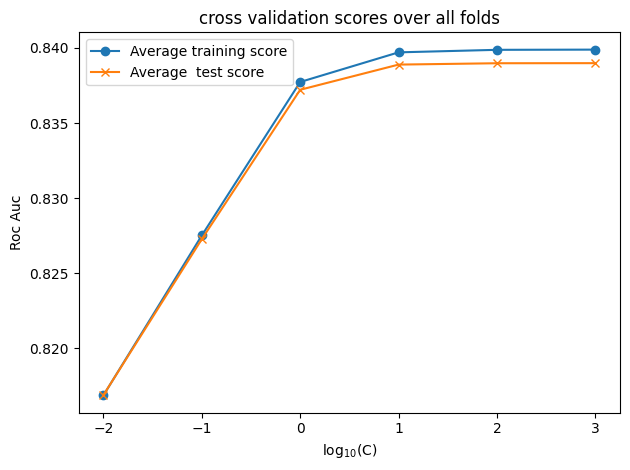

In [111]:
plt.plot(C_vals_exponents_1,np.mean(cv_train_roc_auc_2,axis=0),'-o',
         label='Average training score')
plt.plot(C_vals_exponents_1,np.mean(cv_test_roc_auc_2,axis=0),'-x',
         label='Average  test score')

plt.ylabel('Roc Auc')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('cross validation scores over all folds')
plt.tight_layout()

*We can say that we had again an increase in our model in the test set by introducing an increase in polynomial characteristics combined with the cross-validation and regularization of the model*

*We can see again that for C=10^2, we performed well in the test cases, then we trained the model with this same value*

In [112]:
scale_lr_pipeline.C=10**(2)
scale_lr_pipeline.fit(X_train_2,y_train_2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=1000.0, max_iter=1000, penalty='l1',
                                    solver='saga'))])

*Again, we can see that the performance in the test data is statistically significant relative to the training data, indicating a model that is able to correctly predict the unknown data*

In [113]:
y_proba_roc_test=scale_lr_pipeline.predict_proba(X_test_2)
y_proba_feature_test=metrics.roc_auc_score(y_test_2,y_proba_roc_test[:,1])
y_proba_feature_test

0.8448675679195246

In [114]:
y_proba_roc_train=scale_lr_pipeline.predict_proba(X_train_2)
y_proba_feature_train=metrics.roc_auc_score(y_train_2,y_proba_roc_train[:,1])
y_proba_feature_train

0.8399297267278398

In [115]:
RESUME={
    'Logist_Regression + Anova ROC_AUC_TEST':0.8097920937196019,
    'Logist_Regression + Regularization Ridge + Cross_Validation ROC_AUC_TEST':0.8097920937196019,
    'Logist_Regression + Regularization Ridge + Cross_Validation + Pipeline ROC_AUC_TEST':0.8331583382904043,
    'Logist_Regression + Regularizatino Ridge + Cross_Validation + Pipeline + Polynominal_Features ROC_AUC_TEST':0.8448677080185649
}

for Logist_Regression,Roc_auc_test in RESUME.items():
  print(Logist_Regression,Roc_auc_test)

Logist_Regression + Anova ROC_AUC_TEST 0.8097920937196019
Logist_Regression + Regularization Ridge + Cross_Validation ROC_AUC_TEST 0.8097920937196019
Logist_Regression + Regularization Ridge + Cross_Validation + Pipeline ROC_AUC_TEST 0.8331583382904043
Logist_Regression + Regularizatino Ridge + Cross_Validation + Pipeline + Polynominal_Features ROC_AUC_TEST 0.8448677080185649


*Predict probabilities on the test data*

In [116]:
y_pred_proba_test_csv=scale_lr_pipeline.predict_proba(X_interact_test)

 *Build DataFrame and make first submission*

In [147]:
submission=pd.DataFrame({
    'id':submission_data.id,
    'Smoking':y_pred_proba_test_csv[:,1]
})

In [148]:
submission.to_csv('submission_predict_smoke.csv',
                  index=False)

In [149]:
submission.head(10)

,id,Smoking
0,159256,0.470564
1,159257,0.195816
2,159258,0.503576
3,159259,0.128282
4,159260,0.494635
5,159261,0.789941
6,159262,0.449798
7,159263,0.058357
8,159264,0.113513
9,159265,0.020152
